### Unconstrained sampling with Dirichlet-Laplace shrunkage prior:

In [1]:
import matplotlib.pyplot as plt, numpy as np, numpy.random as npr, pystan as ps, matplotlib.pyplot as plt
from tqdm import trange
import scipy
%matplotlib inline
from time import time
from pylab import plot, show, legend

#### Compile Stan model:

In [2]:
sm = ps.StanModel(file="brain_DL.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d6b2d0b798f12e3033751722baf72ffd NOW.


#### Load data from file and prepare stan data list:

In [8]:
from numpy import loadtxt

X = np.zeros((42,68,68))
for i in range(42) :
    name = "/home/postdoc/dsen/Desktop/projeted_posterior/brain_data/data_column"+str(i+1)
    X[i] = loadtxt(name, comments="#", delimiter=" ", unpack=False)
X = X.astype(int)

# N = 21 
# m = np.shape(X)[1]
# p = 10
# a = 1/m
# data = dict(N=N, R=m, d=p, X=X[:N], alpha=1/m, lmbda=0.5)

N = 21 
m = 10
p = 5
a = 1/m
data = dict(N=N, p=p, m=m, a=a, X=X[:N,:m,:m])

print(np.mean(X[:N,:m,:m]))

0.5571428571428572


#### Sample using stan:

In [9]:
control = dict(max_treedepth=10)
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=4, chains=4, iter=1_000, init="random")
print(round((time()-start)/60,2), "minutes to run")
print(fit)
trace = fit.extract()

40.51 minutes to run
Inference for Stan model: anon_model_d6b2d0b798f12e3033751722baf72ffd.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Z[1,1]        -6.19    1.36    2.1 -11.61  -6.79  -6.12  -4.48  -3.85      2   3.64
Z[2,1]        -2.03    1.25   1.79  -4.53  -3.84  -2.03  -0.22   0.57      2   9.31
Z[3,1]         7.94    1.81   2.64   5.12   5.72   6.43   11.3  12.25      2   5.25
Z[4,1]         0.54    0.33   0.49  -0.05   0.06   0.41   0.97   1.39      2    5.7
Z[5,1]         1.92    0.73   1.08   0.39   0.93   1.86   2.66   3.95      2   5.04
Z[6,1]        -3.56    0.54   0.85  -5.04  -3.97  -3.88  -2.46  -2.22      2   3.02
Z[7,1]         6.41    0.53   1.08   4.33   5.77   6.77   6.86   8.79      4   2.65
Z[8,1]         4.58    0.64   1.07   3.59   4.02   4.17   4.32   7.65      3    2.3
Z[9,1]         5.36    0.85   1.34  

#### Plot posterior means of $U$'s:

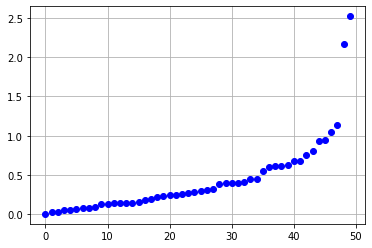

In [10]:
plt.plot(np.sort(np.abs(np.mean(trace['u'],0)).flatten()), 'bo')
plt.grid(True)

#### Look at Stan fit:

In [5]:
fit.get_sampler_params()

[OrderedDict([('accept_stat__',
               array([1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                      1.00000000e+00, 1.00000000e+00, 4.64658492e-01, 4.82581732e-01,
                      8.11190545e-01, 6.98109571e-01, 1.01739526e-01, 8.90149586e-01,
                      8.91643607e-01, 5.37652144e-01, 8.49098756e-01, 9.16557546e-01,
                      4.94188337e-01, 9.83843167e-01, 4.77839476e-01, 9.72632796e-01,
                      7.31764545e-01, 7.50506309e-01, 9.78401156e-01, 6.76791662e-01,
                      9.21696766e-01, 1.01424655e-01, 9.31375453e-01, 9.58605702e-01,
                      7.00814168e-01, 8.38732831e-01, 4.82755093e-01, 9.78187207e-01,
                      8.86493735e-01, 9.89701405e-01, 3.88877607e-01, 8.38434935e-01,
                      6.43254348e-01, 7.18605226e-01, 8.70789447e-01, 9.32805616e-01,
                      6.95576306e-01, 6.28856137e-01, 8.79119637e-01, 5.31263640e-01,
                      

In [9]:
np.shape(trace['u'])

(2000, 20, 3)

In [6]:
n_samples = np.shape(trace['u'])[0]

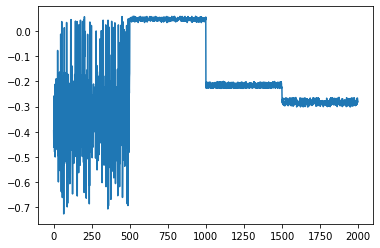

In [7]:
i, j = 1, 3
n = 1

π = trace['Z'][:,i,j] + \
         [trace['u'][idx,i].dot(np.diag(trace['Lambda'][idx,n])).dot(trace['u'][idx,j]) 
          for idx in range(n_samples)]
plt.plot(π);

In [7]:
π_chain = np.zeros((n_samples, N,m,m))
for n in range(N) :
    for i in range(m) :
        for j in range(m) :
            π_chain[:,n,i,j] = trace['Z'][:,i,j] + \
                          [trace['u'][idx,i].dot(np.diag(trace['Lambda'][idx,n])).dot(trace['u'][idx,j]) 
                           for idx in range(np.shape(trace['u'])[0])]

In [8]:
ll = np.zeros(n_samples)
probs = 1/(1+np.exp(-π_chain))
for itr in range(len(ll)) :
    ll[itr] = np.sum(X*np.log(probs[itr]) + (1-X)*np.log(1-probs[itr]))

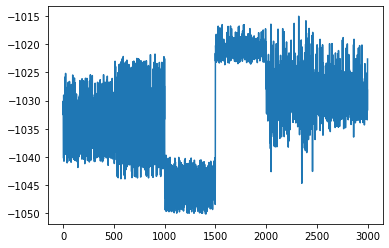

In [9]:
plt.plot(ll)

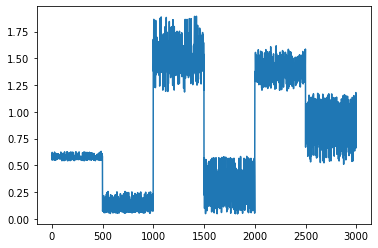

In [12]:
i = 2
plt.plot([scipy.linalg.norm(trace['u'][itr,i,:]) for itr in range(n_samples)])

In [14]:
np.shape(trace['u'])

(3000, 10, 4)

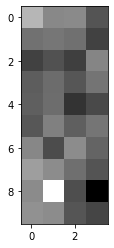

In [20]:
plt.imshow(np.mean(trace['u'],0), cmap="gray")

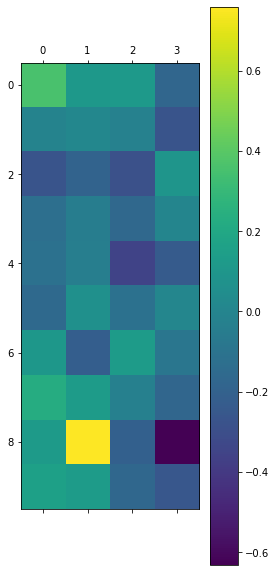

In [22]:
plt.matshow(np.mean(trace['u'],0))
plt.colorbar()

In [26]:
np.shape(trace['u'])

(3000, 10, 4)

In [31]:
np.max(np.linalg.svd(trace['u'][0])[1])

2.3828236660607733

In [33]:
U_normalised = [trace['u'][itr]/np.max(np.linalg.svd(trace['u'][itr])[1]) for itr in range(n_samples)]